In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data

In [ ]:
from google.colab import files

In [ ]:
columns = ['class', 'name', 'image']
df = pd.DataFrame(columns = columns)

In [ ]:
(len(os.listdir('drive/MyDrive/SmileFacesDataset/smile')), 
len(os.listdir('drive/MyDrive/SmileFacesDataset/non_smile')))

(600, 603)

In [ ]:
def folder_to_df(path, class_type):
  for name in tqdm(os.listdir(path)):
    image = Image.open('/'.join([path, name]))
    
    pixel_values = image.load()
    width, height = image.size
    
    new_values = []
    new_values_reversed = []
    
    for i in range(height):
      row = []
      
      for j in range(width):
        current_pixel = int(np.mean(pixel_values[j,i])) / 255
        row.append(np.array(current_pixel).astype('float32'))
      
      new_values.append(row)
      new_values_reversed.append(np.flip(row))
    
    df.loc[len(df)] = [class_type, name, np.array([new_values]).astype('float32')]
    df.loc[len(df)] = [class_type, name + 'rev', np.array([new_values_reversed]).astype('float32')]

In [ ]:
folder_to_df('drive/MyDrive/SmileFacesDataset/smile', 1)
folder_to_df('drive/MyDrive/SmileFacesDataset/non_smile', 0)

100%|██████████| 603/603 [00:42<00:00, 14.03it/s]


In [ ]:
df

,class,name,image
0,1,Jim_Harrick_0001.jpg,"[[[0.42745098, 0.44705883, 0.4745098, 0.509803..."
1,1,Jim_Harrick_0001.jpgrev,"[[[0.43529412, 0.43529412, 0.4392157, 0.447058..."
2,1,Keira_Knightley_0002.jpg,"[[[0.43137255, 0.42745098, 0.42352942, 0.42745..."
3,1,Keira_Knightley_0002.jpgrev,"[[[0.101960786, 0.09019608, 0.09411765, 0.2156..."
4,1,Joseph_Nacchio_0001.jpg,"[[[0.72156864, 0.7372549, 0.77254903, 0.807843..."
...,...,...,...
2401,0,Claire_Tomalin_0001.jpgrev,"[[[0.2627451, 0.3137255, 0.35686275, 0.4392157..."
2402,0,Daniel_Ortega_0001.jpg,"[[[0.14509805, 0.22352941, 0.37254903, 0.53725..."
2403,0,Daniel_Ortega_0001.jpgrev,"[[[0.019607844, 0.003921569, 0.0, 0.007843138,..."
2404,0,David_Nalbandian_0009.jpg,"[[[0.07058824, 0.19607843, 0.32941177, 0.45490..."


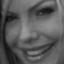

In [ ]:
example = (df['image'][12])[0]
img = Image.fromarray(np.uint8(example * 255), 'L')
display(img)

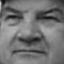

In [ ]:
example = (df['image'][1315])[0]
img = Image.fromarray(np.uint8(example * 255), 'L')
display(img)

In [ ]:
data = df['image']
print(f'Before: {data[0].shape}')
data = [np.array(i[:,:,:,np.newaxis][0]).astype('float32') for i in data]
print(f'After: {data[0].shape}')

Before: (1, 64, 64)
After: (64, 64, 1)


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(np.array(data), 
                                                    np.array(df['class'].astype('int32')), 
                                                    test_size=0.2, 
                                                    random_state=42)
train_x.shape

(1924, 64, 64, 1)

In [ ]:
SIZE = 64

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (4,4), input_shape=(SIZE,SIZE,1), activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(loss='BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 16)        272       
                                                                 
 dropout (Dropout)           (None, 61, 61, 16)        0         
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                                 
 dense (Dense)               (None, 128)               7620736   
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,623,089
Trainable params: 7,623,089
Non-

In [ ]:
class haltCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('loss') <= .1):
          self.model.stop_training = True

train_stop = haltCallback()

In [ ]:
history = model.fit(train_x, train_y, epochs=100, batch_size=32, callbacks=[train_stop])

Epoch 1/100
61/61 [==============================] - 9s 124ms/step - loss: 0.7344 - accuracy: 0.6263
Epoch 2/100
61/61 [==============================] - 9s 140ms/step - loss: 0.3868 - accuracy: 0.8628
Epoch 3/100
61/61 [==============================] - 8s 123ms/step - loss: 0.2428 - accuracy: 0.9044
Epoch 4/100
61/61 [==============================] - 8s 129ms/step - loss: 0.1948 - accuracy: 0.9226
Epoch 5/100
61/61 [==============================] - 13s 215ms/step - loss: 0.1617 - accuracy: 0.9418
Epoch 6/100
61/61 [==============================] - 8s 123ms/step - loss: 0.0987 - accuracy: 0.9688


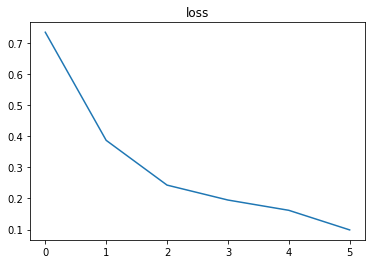

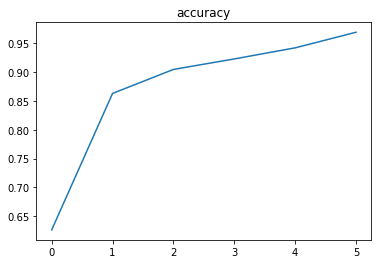

In [ ]:
plt.plot(history.history['loss'])
plt.title("loss")
plt.show()
plt.plot(history.history['accuracy'])
plt.title("accuracy")
plt.show()

In [ ]:
pred_y = model.predict(test_x)
prediction = [1 if i > .5 else 0 for i in pred_y]

16/16 [==============================] - 1s 28ms/step


In [ ]:
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       244
           1       0.90      0.95      0.92       238

    accuracy                           0.92       482
   macro avg       0.92      0.92      0.92       482
weighted avg       0.92      0.92      0.92       482



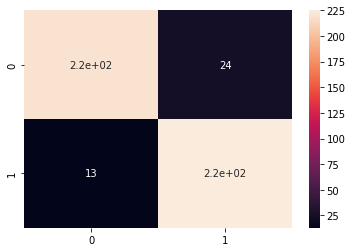

In [ ]:
sns.heatmap(confusion_matrix(test_y, prediction), annot=True)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (4,4), input_shape=(SIZE,SIZE,1), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(loss='BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 3600)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [ ]:
history = model.fit(train_x, train_y, epochs=100, batch_size=32, callbacks=[train_stop])

Epoch 1/100
61/61 [==============================] - 4s 62ms/step - loss: 0.5341 - accuracy: 0.7791
Epoch 2/100
61/61 [==============================] - 4s 64ms/step - loss: 0.2546 - accuracy: 0.9148
Epoch 3/100
61/61 [==============================] - 4s 62ms/step - loss: 0.1695 - accuracy: 0.9439
Epoch 4/100
61/61 [==============================] - 4s 63ms/step - loss: 0.1362 - accuracy: 0.9506
Epoch 5/100
61/61 [==============================] - 4s 62ms/step - loss: 0.1184 - accuracy: 0.9569
Epoch 6/100
61/61 [==============================] - 4s 62ms/step - loss: 0.1026 - accuracy: 0.9605
Epoch 7/100
61/61 [==============================] - 4s 62ms/step - loss: 0.0872 - accuracy: 0.9751


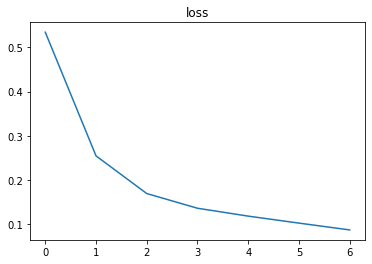

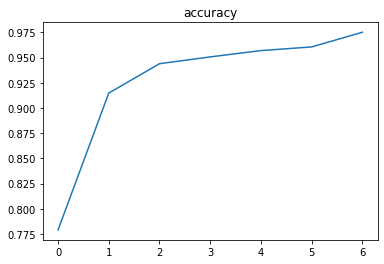

In [ ]:
plt.plot(history.history['loss'])
plt.title("loss")
plt.show()
plt.plot(history.history['accuracy'])
plt.title("accuracy")
plt.show()

In [ ]:
pred_y = model.predict(test_x)
prediction_pooled = [1 if i > .5 else 0 for i in pred_y]

16/16 [==============================] - 0s 19ms/step


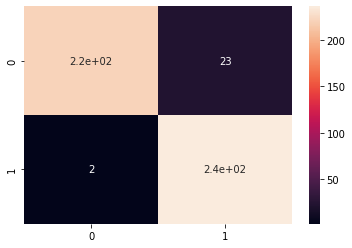

In [ ]:
sns.heatmap(confusion_matrix(test_y, prediction_pooled), annot=True)

In [ ]:
print(classification_report(test_y, prediction_pooled)) # 0.46KK params

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       244
           1       0.91      0.99      0.95       238

    accuracy                           0.95       482
   macro avg       0.95      0.95      0.95       482
weighted avg       0.95      0.95      0.95       482



In [ ]:
print(classification_report(test_y, prediction)) # 7.62KK params

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       244
           1       0.90      0.95      0.92       238

    accuracy                           0.92       482
   macro avg       0.92      0.92      0.92       482
weighted avg       0.92      0.92      0.92       482

